In [1]:
# Imports 
import importlib
import IsTripModel 


In [2]:
# Declare the variable to allow class reloading in the below cell
model = None

In [3]:
importlib.reload(IsTripModel)

class TrainingIsTripModel(IsTripModel.SpacyIsTripModel):
    def prepare_data(self, data):
        prepared_data = []
        for item in data:
            text = item['sentence']
            # We consider a travel when exactly two entities are present
            # We may modify this later to handle more complex travels with a list of checkpoints (like Nantes -> Paris -> Marseille)
            is_travel = len(item['entities']) == 2
            prepared_data.append((text, {"cats": {self.true_category: is_travel, self.false_category: not is_travel}}))
        return prepared_data

# Refresh the methods of the model if it was already instanciated
if model:
    model.__class__ = TrainingIsTripModel
    TrainingIsTripModel.refresh_methods(model)

In [4]:
# Load data
model = TrainingIsTripModel()

# Training

In [5]:
num_positives = len([item for item in model.train_data if item[1]["cats"]["TRAVEL"]])
num_negatives = len([item for item in model.train_data if item[1]["cats"]["NOT_TRAVEL"]])
print(f"Number of travels : {num_positives}, number of non travels : {num_negatives}")
print(f"Training example : {model.train_data[0]}")


Number of travels : 2415, number of non travels : 2385
Training example : ('je pars de la ferte-sous-jouarre pour aller à bois-le-roi ce week-end avec ma famille.', {'cats': {'TRAVEL': True, 'NOT_TRAVEL': False}})


In [6]:
# Model creation
model.load_model("fr_core_news_md")

In [7]:
# Training
model.train(4)

Iteration 1, losses : {'textcat': 8.613915093168243}
Iteration 2, losses : {'textcat': 2.752359192284765e-06}
Iteration 3, losses : {'textcat': 1.1257984524806465e-07}
Iteration 4, losses : {'textcat': 3.854460179245781e-07}


In [8]:
# Save the model
model.save("model_is_trip_trained")

# Testing

In [9]:
not_trained = TrainingIsTripModel("fr_core_news_md")

Model: Trained Model


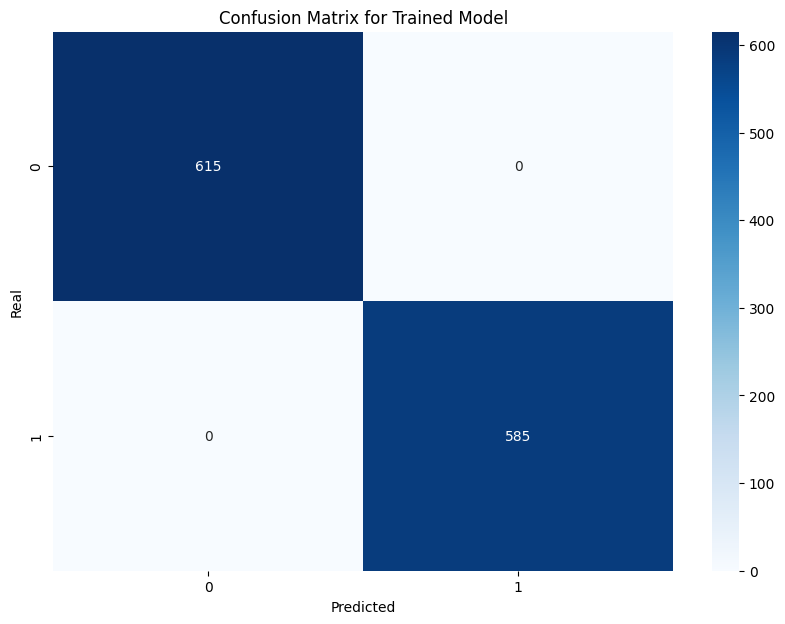

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       615
        True       1.00      1.00      1.00       585

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

Model: Not Trained Model


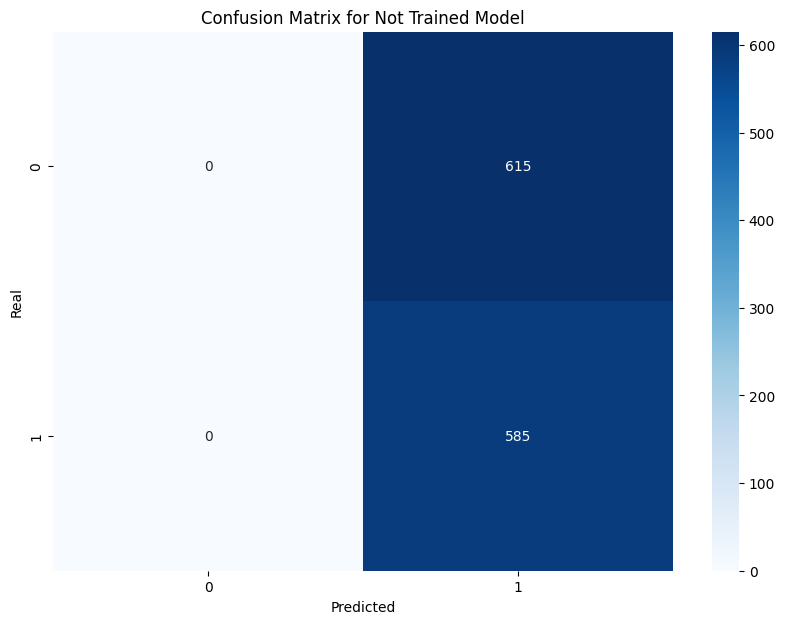

Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       615
        True       0.49      1.00      0.66       585

    accuracy                           0.49      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.24      0.49      0.32      1200



/home/landreas/delivery/T-AIA/AYAAAAAA/venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/landreas/delivery/T-AIA/AYAAAAAA/venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/landreas/delivery/T-AIA/AYAAAAAA/venv/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [10]:
model.evaluate_model(model.test_data, "Trained Model")
# We can test an untrained model but it raises warnings because the model is not trained yet
not_trained.evaluate_model(not_trained.test_data, "Not Trained Model")

# Validation

Model: Trained Model


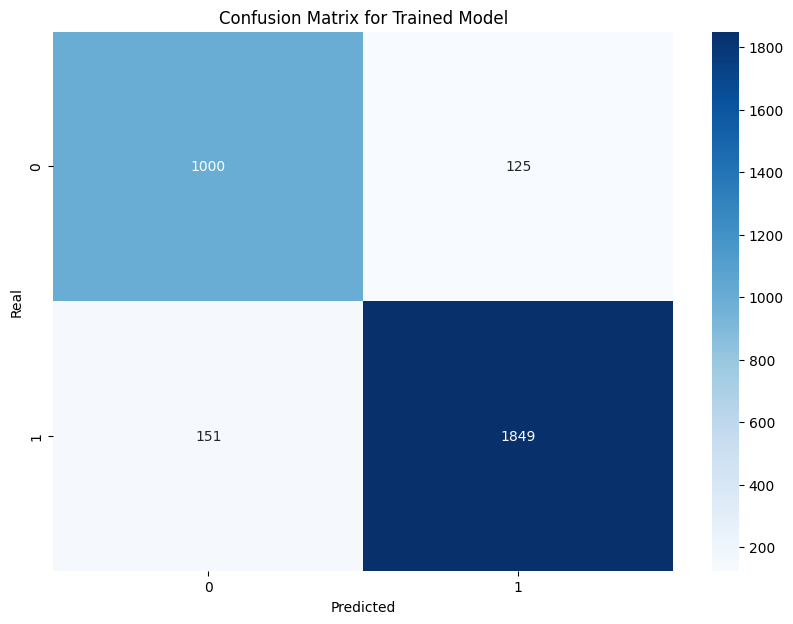

Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.89      0.88      1125
        True       0.94      0.92      0.93      2000

    accuracy                           0.91      3125
   macro avg       0.90      0.91      0.90      3125
weighted avg       0.91      0.91      0.91      3125



In [11]:
model.evaluate_model(model.validation_data, "Trained Model")